# Example preprocessing of an IFS cube

> Author: *Valentin Christiaens*  
> Last update: *2022/04/12*

### Table of contents

* [1. Loading and visualizing the data](#1.-Loading-and-visualizing-the-data)

* [2. Preprocessing](#2.-Preprocessing)
    - [2.1. Bad pixel correction](#2.1.-Bad-pixel-correction)
    - [2.2. Bad frame removal](#2.2.-Bad-frame-removal)

The purpose of this tutorial is to show how to further improve the quality of IFS data cubes provided in the phase 2 of the Exoplanet Data Challenge (as is from each instrument's official pipeline), before applying your favourite post-processing algorithms to detect the injected planets. 

Specifically, we show how to use the relevant functions of the `VIP` package in order to correct for remaining bad pixels and remove bad frames in the second SPHERE/IFS datacube used in the data challenge.

-----------

Let's first import the packages needed in this tutorial:

In [1]:
from hciplot import plot_frames, plot_cubes
from matplotlib import pyplot as plt
import numpy as np
from os.path import isfile

from vip_hci.fits import open_fits, write_fits
from vip_hci.preproc import cube_detect_badfr_correlation, cube_fix_badpix_clump, cube_fix_badpix_with_kernel

## 1. Loading and visualizing the data

In the 'dataset' folder of the `phase2` repository you can find a toy SPHERE/IFS coronagraphic cube acquired in pupil-stabilized mode on the source HIP39826 (a star with no reported directly imaged companion). The folder also contains the associated non-coronagraphic point spread function (PSF), wavelength vector and parallactic angles (the latter also including information on the airmass of the source).

Let's now load the data. Note that more info on opening and visualizing fits files with VIP in general is available [in the first VIP tutorial](https://vip.readthedocs.io/en/latest/tutorials/01_quickstart.html).

**Replace next box when zenodo link available**

In [2]:
path = '/Users/Valentin/Documents/Postdoc/EIDC/Cubes/data_test/'
datpath = path+'datasets/'

cubename = datpath+'image_cube_sphere2.fits'
angname = datpath+'parallactic_angles_sphere2.fits'

cube = open_fits(cubename)
pa = open_fits(angname)
derot_angles = pa[0]

nch, nz, ny, nx = cube.shape

Fits HDU-0 data successfully loaded. Data shape: (39, 65, 189, 189)
Fits HDU-0 data successfully loaded. Data shape: (2, 65)


Each IFS spectral cube consists of 39 monochromatic images spread in wavelengths between the Y and J bands ('YJ' mode) or Y and H bands ('YJH' mode). Here the IFS+ADI cube contains 65 such spectral cubes combined into a single master cube. The first column of the parallactic angle file actually contains the parallactic (derotation) angles, while the second columns contains the airmass at which each spectral cube was obtained.

The **master spectral cube** is already centered. Let's inspect the first and last wavelengths, using `hciplot.plot_cubes` (feel free to set the backend to 'bokeh' to read pixel values interactively):

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
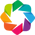

:Dataset   [x,y,time,lambda]   (flux)
:Cube_shape	[189, 189, 65, 39]


:DynamicMap   [time,lambda]
   :Image   [x,y]   (flux)

In [37]:
plot_cubes(cube, backend='bokeh', vmax=15)

Inspection of the master cube shows the presence of residual bad pixels (e.g. at time 30 of lambda 0), and the presence of frames very different from the others (specifically for time > 60).

In the next section, we will show how to better prepare the master cube by correcting bad pixels and trimming bad frames, in order to increase the performance of typical post-processing algorithms.

[Go to the top](#Table-of-contents)

## 2. Preprocessing

### 2.1. Bad pixel correction

Let's first identify static bad pixels. Since the frames have been shifted while residual bad pixels were still present, they do form clumps. We therefore use the iterative sigma filtering algorithm implemented in `VIP`, applied to the mean frame (temporal dimension) at each wavelength. The first pass identifies the bad pixel maps, which are then used for correction in the second pass. Note that we set a minimum absolute threshold `min_thr` to minimize false positives while identifying bad pixels:

In [10]:
_, bpm_mask_static = cube_fix_badpix_clump(np.mean(cube, axis=1), fwhm=6., sig=4, mad=True, max_nit=5,
                                           min_thr=(-0.5,4), verbose=True, full_output=True) 
cube_corr = cube.copy()
for i in range(nch):
    cube_corr[i] = cube_fix_badpix_clump(cube[i], bpm_mask=bpm_mask_static[i], fwhm=6.)

************Frame #  0  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  1  *************
All bad pixels are corrected.
************Frame #  2  *************
All bad pixels are corrected.
************Frame #  3  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  6  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  7  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  8  *************
It

************Frame #  32  *************
************Frame #  33  *************
************Frame #  34  *************
************Frame #  35  *************
************Frame #  36  *************
************Frame #  37  *************
************Frame #  38  *************
************Frame #  39  *************
************Frame #  40  *************
************Frame #  41  *************
************Frame #  42  *************
************Frame #  43  *************
************Frame #  44  *************
************Frame #  45  *************
************Frame #  46  *************
************Frame #  47  *************
************Frame #  48  *************
************Frame #  49  *************
************Frame #  50  *************
************Frame #  51  *************
************Frame #  52  *************
************Frame #  53  *************
************Frame #  54  *************
************Frame #  55  *************
************Frame #  56  *************
************Frame #  57  

************Frame #  9  *************
************Frame #  10  *************
************Frame #  11  *************
************Frame #  12  *************
************Frame #  13  *************
************Frame #  14  *************
************Frame #  15  *************
************Frame #  16  *************
************Frame #  17  *************
************Frame #  18  *************
************Frame #  19  *************
************Frame #  20  *************
************Frame #  21  *************
************Frame #  22  *************
************Frame #  23  *************
************Frame #  24  *************
************Frame #  25  *************
************Frame #  26  *************
************Frame #  27  *************
************Frame #  28  *************
************Frame #  29  *************
************Frame #  30  *************
************Frame #  31  *************
************Frame #  32  *************
************Frame #  33  *************
************Frame #  34  *

************Frame #  43  *************
************Frame #  44  *************
************Frame #  45  *************
************Frame #  46  *************
************Frame #  47  *************
************Frame #  48  *************
************Frame #  49  *************
************Frame #  50  *************
************Frame #  51  *************
************Frame #  52  *************
************Frame #  53  *************
************Frame #  54  *************
************Frame #  55  *************
************Frame #  56  *************
************Frame #  57  *************
************Frame #  58  *************
************Frame #  59  *************
************Frame #  60  *************
************Frame #  61  *************
************Frame #  62  *************
************Frame #  63  *************
************Frame #  64  *************
************Frame #  0  *************
************Frame #  1  *************
************Frame #  2  *************
************Frame #  3  ****

************Frame #  21  *************
************Frame #  22  *************
************Frame #  23  *************
************Frame #  24  *************
************Frame #  25  *************
************Frame #  26  *************
************Frame #  27  *************
************Frame #  28  *************
************Frame #  29  *************
************Frame #  30  *************
************Frame #  31  *************
************Frame #  32  *************
************Frame #  33  *************
************Frame #  34  *************
************Frame #  35  *************
************Frame #  36  *************
************Frame #  37  *************
************Frame #  38  *************
************Frame #  39  *************
************Frame #  40  *************
************Frame #  41  *************
************Frame #  42  *************
************Frame #  43  *************
************Frame #  44  *************
************Frame #  45  *************
************Frame #  46  

************Frame #  3  *************
************Frame #  4  *************
************Frame #  5  *************
************Frame #  6  *************
************Frame #  7  *************
************Frame #  8  *************
************Frame #  9  *************
************Frame #  10  *************
************Frame #  11  *************
************Frame #  12  *************
************Frame #  13  *************
************Frame #  14  *************
************Frame #  15  *************
************Frame #  16  *************
************Frame #  17  *************
************Frame #  18  *************
************Frame #  19  *************
************Frame #  20  *************
************Frame #  21  *************
************Frame #  22  *************
************Frame #  23  *************
************Frame #  24  *************
************Frame #  25  *************
************Frame #  26  *************
************Frame #  27  *************
************Frame #  28  *******

************Frame #  62  *************
************Frame #  63  *************
************Frame #  64  *************
************Frame #  0  *************
************Frame #  1  *************
************Frame #  2  *************
************Frame #  3  *************
************Frame #  4  *************
************Frame #  5  *************
************Frame #  6  *************
************Frame #  7  *************
************Frame #  8  *************
************Frame #  9  *************
************Frame #  10  *************
************Frame #  11  *************
************Frame #  12  *************
************Frame #  13  *************
************Frame #  14  *************
************Frame #  15  *************
************Frame #  16  *************
************Frame #  17  *************
************Frame #  18  *************
************Frame #  19  *************
************Frame #  20  *************
************Frame #  21  *************
************Frame #  22  **********

Let's now identify individual bad pixels in each frame (e.g. due to cosmic rays) with an iterative algorithm (suited to correct bad pixel clumps), and add them to the static bad pixel map (**warning: this may take up to a few hours depending on your machine**).

In [11]:
overwrite = False

if not isfile(datpath+"master_bad_pixel_map.fits") or overwrite:
    bpm_mask = np.zeros([nch, nz, ny, nx])
    for i in range(nch):
        cube_corr[i], bpm_mask_indiv = cube_fix_badpix_clump(cube_corr[i], fwhm=6, sig=4,
                                                             mad=True, min_thr=(-0.5,3),
                                                             verbose=True, full_output=True) 
        for z in range(nz):
            bpm_mask[i,z] = bpm_mask_indiv[z]+bpm_mask_static[i]

    bpm_mask[np.where(bpm_mask>1)]=1       
    write_fits(datpath+"master_bad_pixel_map.fits", bpm_mask)

************Frame #  0  *************
All bad pixels are corrected.
************Frame #  1  *************
All bad pixels are corrected.
************Frame #  2  *************
All bad pixels are corrected.
************Frame #  3  *************
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  6  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  7  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  8  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  9  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
********

Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  13  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  14  *************
All bad pixels are corrected.
************Frame #  15  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  17  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
**

Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  14  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  15  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  17  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Fra

Iteration 1: 11.0 bpix in total, 11.0 to be corrected
All bad pixels are corrected.
************Frame #  12  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
Iteration 2: 4.0 bpix in total, 4.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  13  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  14  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  15  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  17  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 20.0 bpix in total, 20.0 to 

Iteration 1: 26.0 bpix in total, 26.0 to be corrected
All bad pixels are corrected.
************Frame #  3  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 20.0 bpix in total, 20.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
All bad pixels are corrected.
************Frame #  6  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  7  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  8  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  9  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be 

Iteration 3: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  60  *************
Iteration 1: 28.0 bpix in total, 28.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  61  *************
Iteration 1: 23.0 bpix in total, 23.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  62  *************
Iteration 1: 36.0 bpix in total, 36.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
Iteration 4: 1.0 bpix in total, 1.0 to be corrected
Iteration 5: 1.0 bpix in total, 1.0 to be corrected
Iteration 6: 1.0 bpix in total, 1.0 to be corrected
Iteration 7: 1.0 bpix in total, 1.0 to be corrected
Iteration 8: 1.0 bpix in total, 1.0 to be corrected
Iteration 9: 1.0 bpix in total, 1.0 to be corrected
Iteration 10: 1.0 bpix in total, 1.0 to be corrected
Iterat

Iteration 7: 1.0 bpix in total, 1.0 to be corrected
Iteration 8: 1.0 bpix in total, 1.0 to be corrected
Iteration 9: 1.0 bpix in total, 1.0 to be corrected
Iteration 10: 1.0 bpix in total, 1.0 to be corrected
Iteration 11: 1.0 bpix in total, 1.0 to be corrected
Iteration 12: 1.0 bpix in total, 1.0 to be corrected
Iteration 13: 1.0 bpix in total, 1.0 to be corrected
Iteration 14: 1.0 bpix in total, 1.0 to be corrected
Iteration 15: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  37  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 19.0 bpix in total, 19.0 to be corrected
All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 23.0 bpix in total, 23.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  40

Iteration 1: 20.0 bpix in total, 20.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 18.0 bpix in total, 18.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  21  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  22  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  23  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  24  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  2

Iteration 2: 4.0 bpix in total, 4.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  63  *************
Iteration 1: 26.0 bpix in total, 26.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  64  *************
Iteration 1: 37.0 bpix in total, 37.0 to be corrected
All bad pixels are corrected.
************Frame #  0  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
All bad pixels are corrected.
************Frame #  1  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
All bad pixels are corrected.
************Frame #  2  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
All bad pixels are corrected.
************Frame #  3  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 14.0 bpix in total, 14.0 to be 

Iteration 2: 1.0 bpix in total, 1.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
Iteration 4: 1.0 bpix in total, 1.0 to be corrected
Iteration 5: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  51  *************
Iteration 1: 21.0 bpix in total, 21.0 to be corrected
All bad pixels are corrected.
************Frame #  52  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  53  *************
Iteration 1: 21.0 bpix in total, 21.0 to be corrected
All bad pixels are corrected.
************Frame #  54  *************
Iteration 1: 44.0 bpix in total, 44.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  55  *************
Iteration 1: 30.0 bpix in total, 30.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are co

Iteration 1: 21.0 bpix in total, 21.0 to be corrected
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 20.0 bpix in total, 20.0 to be corrected
All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 18.0 bpix in total, 18.0 to be corrected
All bad pixels are corrected.
************Frame #  40  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  41  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 18.0 bpix in total, 18.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
Iteration 1: 31.0 bpix in total, 31.0 to be corrected
All bad pixels are corrected.
************Frame #  4

Iteration 1: 41.0 bpix in total, 41.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  27  *************
Iteration 1: 23.0 bpix in total, 23.0 to be corrected
All bad pixels are corrected.
************Frame #  28  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  29  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
All bad pixels are corrected.
************Frame #  30  *************
Iteration 1: 51.0 bpix in total, 51.0 to be corrected
Iteration 2: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  31  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
All bad pixels are corrected.
************Frame #  32  *************
Iteration 1: 23.0 bpix in total, 23.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected


Iteration 1: 21.0 bpix in total, 21.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
All bad pixels are corrected.
************Frame #  17  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 26.0 bpix in total, 26.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 18.0 bpix in total, 18.0 to be corrected
All bad pixels are corrected.
************Frame #  21  *************
Iteration 1: 21.0 bpix in total, 21.0 to be corrected
All bad pixels are corrected.
************Frame #  22  *************
Iteration 1: 18.0 bpix in total, 18.0

Iteration 1: 13.0 bpix in total, 13.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  2  *************
Iteration 1: 30.0 bpix in total, 30.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  3  *************
Iteration 1: 26.0 bpix in total, 26.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  6  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
All bad pixels are corrected.
************Frame #  7  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
Iterat

All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 20.0 bpix in total, 20.0 to be corrected
All bad pixels are corrected.
************Frame #  46  *************
Iteration 1: 37.0 bpix in total, 37.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  47  *************
Iteration 1: 21.0 bpix in total, 21.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  48  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  49  *************
Iteration 1: 20.0 bpix in total, 20.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
Iteration 4: 1.0 bpix in total, 1.0 to be corrected
Iteration 5: 1.0 bpix in total, 1.0 to be corrected
Iteration 6: 1.0 bpix in total, 1.0 to be corrected
Iteration 7: 1.0 bpix

Iteration 1: 26.0 bpix in total, 26.0 to be corrected
All bad pixels are corrected.
************Frame #  27  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  28  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
All bad pixels are corrected.
************Frame #  29  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
All bad pixels are corrected.
************Frame #  30  *************
Iteration 1: 28.0 bpix in total, 28.0 to be corrected
All bad pixels are corrected.
************Frame #  31  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  32  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
All bad pixels are corrected.
************Frame #  33  *************
Iteration 1: 23.0 bpix in total, 23

Iteration 13: 1.0 bpix in total, 1.0 to be corrected
Iteration 14: 1.0 bpix in total, 1.0 to be corrected
Iteration 15: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
All bad pixels are corrected.
************Frame #  6  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  7  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  8  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  9  *************
Iteration 1: 19.0 bpix in total, 19.0 to be corrected
All bad pixels are corrected.
************Frame #  10  *************
Iteratio

Iteration 1: 34.0 bpix in total, 34.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  53  *************
Iteration 1: 26.0 bpix in total, 26.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  54  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  55  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  56  *************
Iteration 1: 67.0 bpix in total, 67.0 to be corrected
Iteration 2: 5.0 bpix in total, 5.0 to be corrected
Iteration 3: 2.0 bpix in total, 2.0 to be corrected
Iteration 4: 1.0 bpix in total, 1.0 to be corrected
Iteration 5: 1.0 bpix in total, 1.0 to be corrected
Iteration 6: 1.0 bpix in total, 1.0 to b

Iteration 1: 30.0 bpix in total, 30.0 to be corrected
All bad pixels are corrected.
************Frame #  32  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  33  *************
Iteration 1: 43.0 bpix in total, 43.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  34  *************
Iteration 1: 24.0 bpix in total, 24.0 to be corrected
All bad pixels are corrected.
************Frame #  35  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  36  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  37  *************
Iteration 1: 24.0 bpix in total, 24.0 to be corrected
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 21.0 bpix in total, 21

All bad pixels are corrected.
************Frame #  25  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  26  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
All bad pixels are corrected.
************Frame #  27  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  28  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  29  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  30  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  31  *************
Iteration 1: 39.0 bpix in total, 39.0 to be

All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  21  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  22  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  23  *************
All bad pixels are corrected.
************Frame #  24  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  25  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  26  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  27  *************
Iteration 1: 

All bad pixels are corrected.
************Frame #  22  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  23  *************
All bad pixels are corrected.
************Frame #  24  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  25  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  26  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  27  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  28  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  29  *************
Iteration 1: 4.0 bpix in total, 

All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  21  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  22  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  23  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  24  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  25  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  26  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #

Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
All bad pixels are corrected.
************Frame #  17  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  21  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  22  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  23  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
**

All bad pixels are corrected.
************Frame #  12  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  13  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  14  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  15  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
All bad pixels are corrected.
************Frame #  17  *************
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels 

Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  8  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
All bad pixels are corrected.
************Frame #  9  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  10  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  11  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  12  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  13  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  14  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Fra

All bad pixels are corrected.
************Frame #  1  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected
All bad pixels are corrected.
************Frame #  2  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  3  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  6  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  7  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  8  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected

All bad pixels are corrected.
************Frame #  61  *************
Iteration 1: 38.0 bpix in total, 38.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  62  *************
Iteration 1: 53.0 bpix in total, 53.0 to be corrected
Iteration 2: 10.0 bpix in total, 10.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  63  *************
Iteration 1: 51.0 bpix in total, 51.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  64  *************
Iteration 1: 37.0 bpix in total, 37.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  0  *************
Iteration 1: 22.0 bpix in total, 22.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are c

All bad pixels are corrected.
************Frame #  55  *************
Iteration 1: 23.0 bpix in total, 23.0 to be corrected
All bad pixels are corrected.
************Frame #  56  *************
Iteration 1: 49.0 bpix in total, 49.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  57  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
All bad pixels are corrected.
************Frame #  58  *************
Iteration 1: 37.0 bpix in total, 37.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  59  *************
Iteration 1: 27.0 bpix in total, 27.0 to be corrected
All bad pixels are corrected.
************Frame #  60  *************
Iteration 1: 52.0 bpix in total, 52.0 to be corrected
Iteration 2: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  61  *************
Iteration 1: 42.0 bpix in total, 42.0

Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  49  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
All bad pixels are corrected.
************Frame #  50  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  51  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  52  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  53  *************
Iteration 1: 29.0 bpix in total, 29.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  54  *************
Iteration 1: 24.0 bpix in total, 24.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  55  *

Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 18.0 bpix in total, 18.0 to be corrected
All bad pixels are corrected.
************Frame #  40  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  41  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  44  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 7.0 bpix in t

All bad pixels are corrected.
************Frame #  26  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  27  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  28  *************
Iteration 1: 14.0 bpix in total, 14.0 to be corrected
All bad pixels are corrected.
************Frame #  29  *************
Iteration 1: 20.0 bpix in total, 20.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  30  *************
Iteration 1: 19.0 bpix in total, 19.0 to be corrected
All bad pixels are corrected.
************Frame #  31  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  32  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  33  *************
Iteration 1: 27.0 bpix i

All bad pixels are corrected.
************Frame #  13  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  14  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  15  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  16  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  17  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  18  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  19  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  20  *************
Iteration 1: 19.0 bpix in 

Iteration 1: 62.0 bpix in total, 62.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  64  *************
Iteration 1: 65.0 bpix in total, 65.0 to be corrected
Iteration 2: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  0  *************
Iteration 1: 18.0 bpix in total, 18.0 to be corrected
All bad pixels are corrected.
************Frame #  1  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  2  *************
Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  3  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  4  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  5  *******

Iteration 1: 23.0 bpix in total, 23.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  59  *************
Iteration 1: 36.0 bpix in total, 36.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  60  *************
Iteration 1: 39.0 bpix in total, 39.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  61  *************
Iteration 1: 41.0 bpix in total, 41.0 to be corrected
All bad pixels are corrected.
************Frame #  62  *************
Iteration 1: 69.0 bpix in total, 69.0 to be corrected
Iteration 2: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  63  *************
Iteration 1: 84.0 bpix in total, 84.0 to be corrected
Iteration 2: 7.0 bpix in total, 7.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are 

Iteration 1: 15.0 bpix in total, 15.0 to be corrected
All bad pixels are corrected.
************Frame #  53  *************
Iteration 1: 36.0 bpix in total, 36.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  54  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  55  *************
Iteration 1: 24.0 bpix in total, 24.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  56  *************
Iteration 1: 41.0 bpix in total, 41.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  57  *************
Iteration 1: 24.0 bpix in total, 24.0 to be corrected
All bad pixels are corrected.
************Frame #  58  *************
Iteration 1: 16.0 bpix in total, 16.0 to be corrected


Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  49  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  50  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  51  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  52  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  53  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  54  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  55  *************
Iteration 1: 25.0 bpix in total, 25.0 to 

Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  46  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  47  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  48  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  49  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  50  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  51  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #

Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 12.0 bpix in total, 12.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
Iteration 1: 11.0 bpix in total, 11.0 to be corrected
All bad pixels are corrected.
************Frame #  44  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  46  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  47  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  48  *************
Iteration 1: 9.0 bpix in total, 9.0 to be cor

All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 17.0 bpix in total, 17.0 to be corrected
All bad pixels are corrected.
************Frame #  40  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  41  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  44  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 13.0 bpix in total, 13.0 to be corrected
Iteration 2: 2.0 bpix in total, 2.0 to be corrected
Iteration 3: 1.0 bpix in total, 1.0 to be

Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  37  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
Iteration 2: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 25.0 bpix in total, 25.0 to be corrected
Iteration 2: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  40  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  41  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
Iteration 1: 12.0 bpix in total, 12.0 to be cor

All bad pixels are corrected.
************Frame #  37  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 10.0 bpix in total, 10.0 to be corrected
All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 9.0 bpix in total, 9.0 to be corrected
All bad pixels are corrected.
************Frame #  40  *************
Iteration 1: 8.0 bpix in total, 8.0 to be corrected
All bad pixels are corrected.
************Frame #  41  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 6.0 bpix in total, 6.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  44  *************
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 

Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  37  *************
All bad pixels are corrected.
************Frame #  38  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  39  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  40  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  41  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  42  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  43  *************
All bad pixels are corrected.
************Frame #  44  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 8.

All bad pixels are corrected.
************Frame #  43  *************
All bad pixels are corrected.
************Frame #  44  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  45  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  46  *************
All bad pixels are corrected.
************Frame #  47  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  48  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  49  *************
Iteration 1: 3.0 bpix in total, 3.0 to be corrected
All bad pixels are corrected.
************Frame #  50  *************
Iteration 1: 2.0 bpix in total, 2.0 to be corrected
All bad pixels are corrected.
************Frame #  51  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels 

Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  47  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  48  *************
Iteration 1: 4.0 bpix in total, 4.0 to be corrected
All bad pixels are corrected.
************Frame #  49  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  50  *************
Iteration 1: 1.0 bpix in total, 1.0 to be corrected
All bad pixels are corrected.
************Frame #  51  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  52  *************
Iteration 1: 5.0 bpix in total, 5.0 to be corrected
All bad pixels are corrected.
************Frame #  53  *************
Iteration 1: 7.0 bpix in total, 7.0 to be corrected
All bad pixels are corrected.
************Frame #  54  *************
Iteration 1: 3.0 bpix in total, 

Let's now correct all identified bad pixels with a Gaussian kernel:

In [23]:
bpm_mask = open_fits(datpath+"master_bad_pixel_map.fits")
for i in range(nch):
    cube_corr[i] = cube_fix_badpix_with_kernel(cube[i], bpm_mask=bpm_mask[i], mode='gauss', fwhm=1)

Fits HDU-0 data successfully loaded. Data shape: (39, 65, 189, 189)


Let's compare 2 frames before and after bad pixel correction:

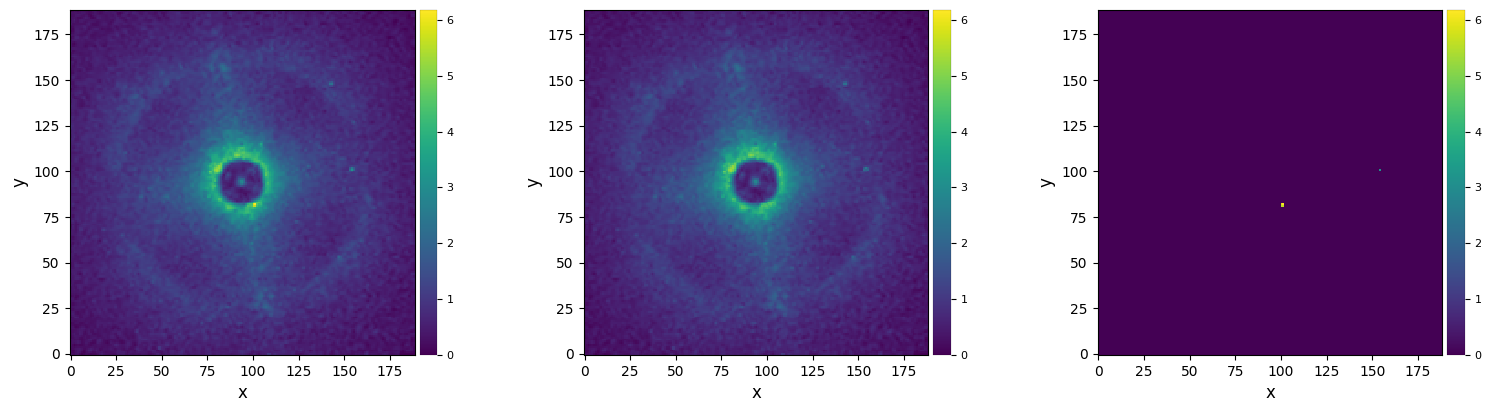

In [24]:
%matplotlib inline
idx = 7
plot_frames((cube[0,idx], cube_corr[0,idx], bpm_mask[0,idx]*cube[0,idx]), 
            vmin=0, vmax=float(np.amax(cube[0,idx])))

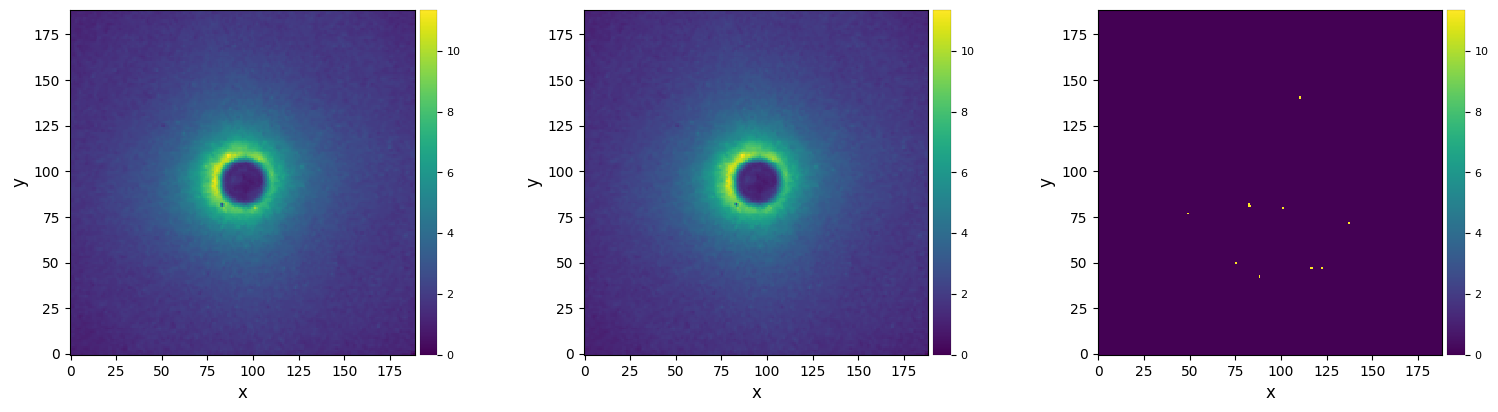

In [29]:
idx = -2
plot_frames((cube[-1,idx], cube_corr[-1,idx], np.abs(bpm_mask[-1,idx]*np.amax(cube[-1,idx]))), 
            vmin=0, vmax=float(np.amax(cube[-1,idx])))

Note that it may be possible to obtain better bad pixel corrections by tweaking the parameters of each routine used to identify them (such as `sigma_clip`, `size`, `sig` or `min_thr`).

[Go to the top](#Table-of-contents)

### 2.2. Bad frames trim

Let's now remove bad frames, based on the cross-correlation between each frame and the median of the ADI sequence (at each wavelength). We use the Structural Similarity (SSIM) index (REF), computed in an annular region beyond the coronagraphic mask. It is worth running a first pass of the algorithm using a percentile threshold, plot the values for each cube, and then  define an absolute threshold based on the mean SSIM values (over all wavelengths):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.039417
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.034479
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0

/Users/valentin/GitHub/VIP/vip_hci/preproc/badframes.py:332: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=vip_figsize)


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.035338
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.034086
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0

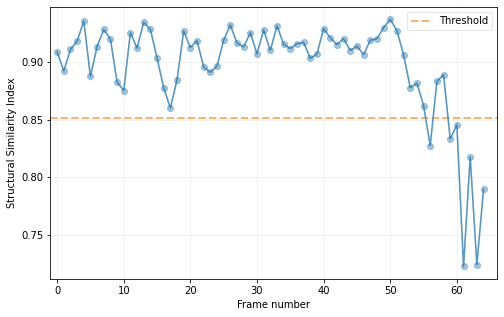

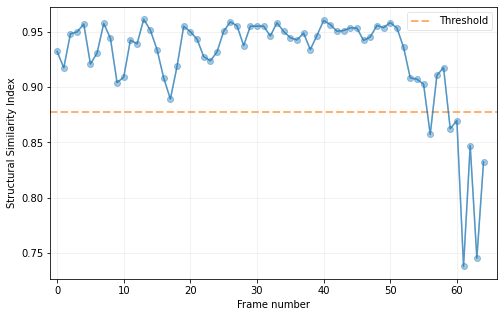

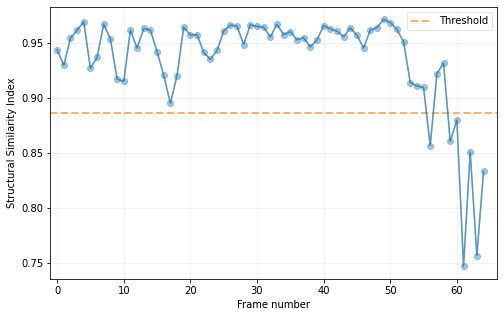

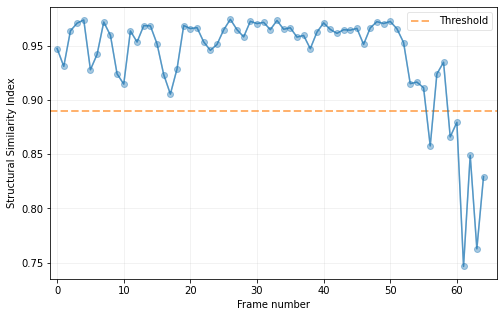

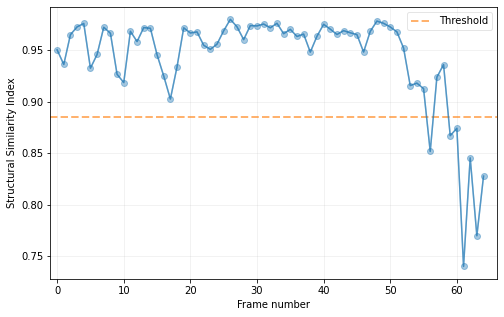

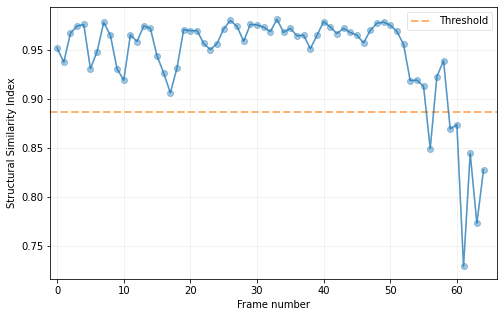

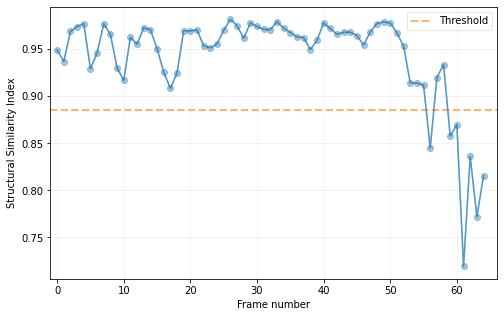

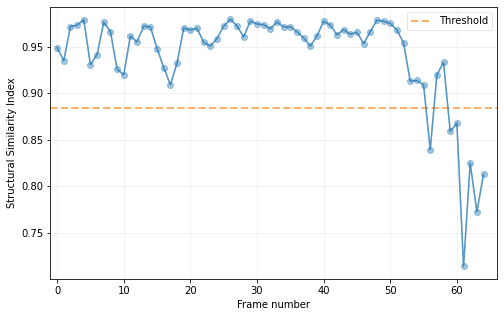

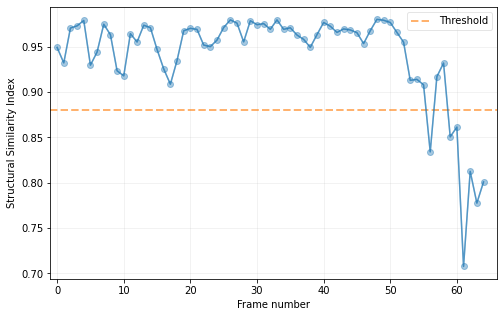

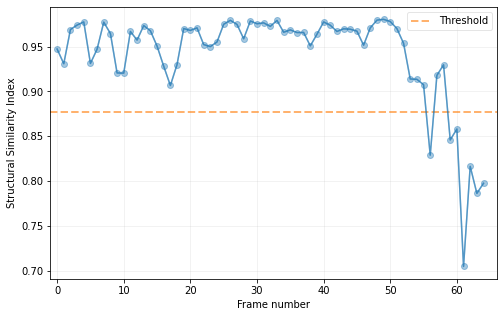

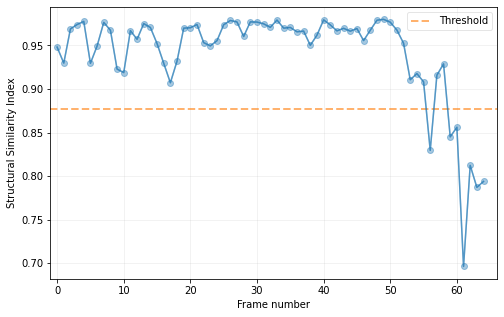

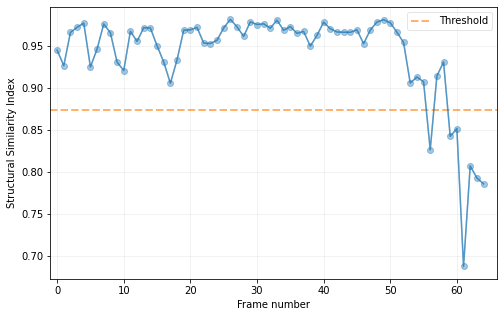

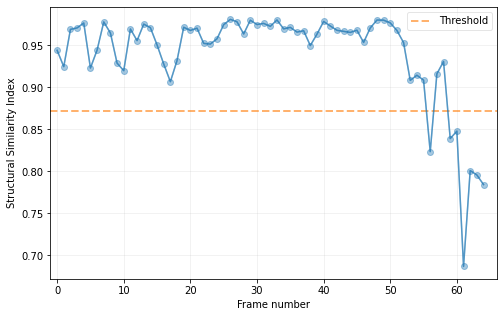

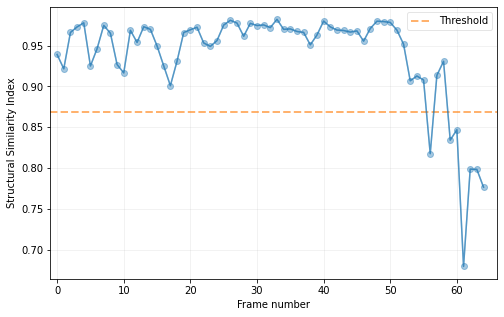

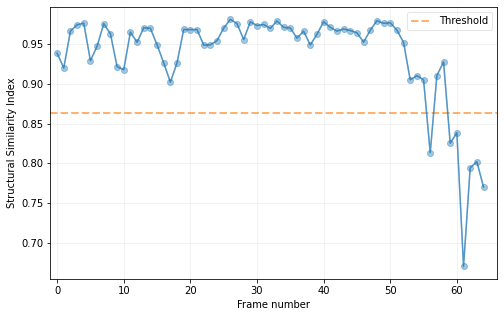

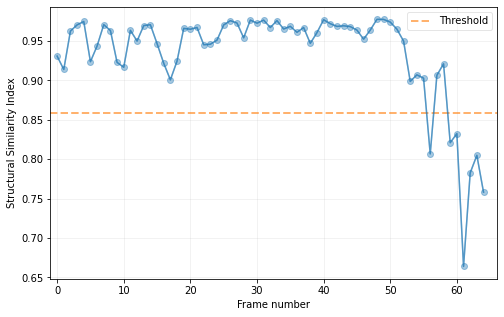

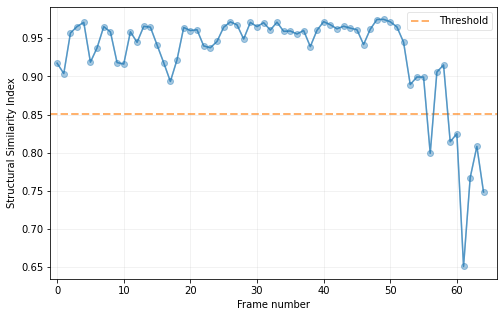

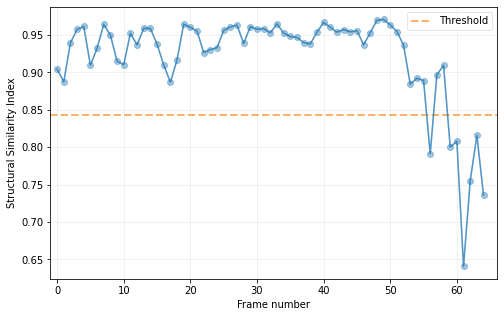

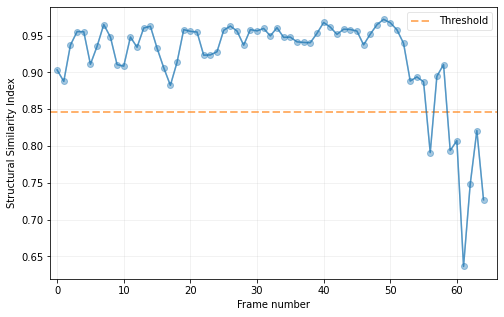

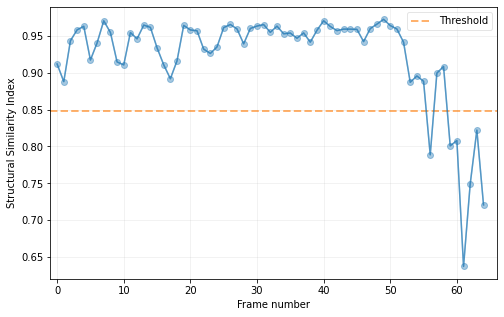

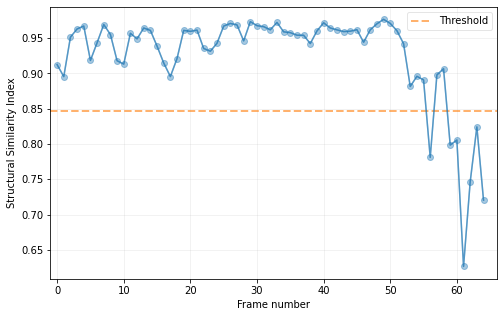

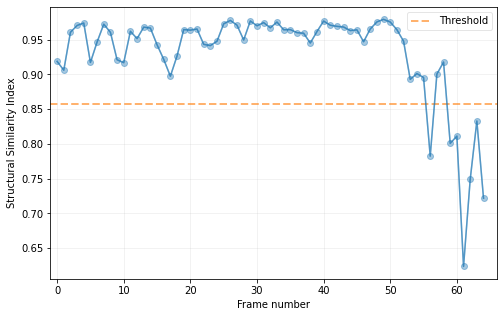

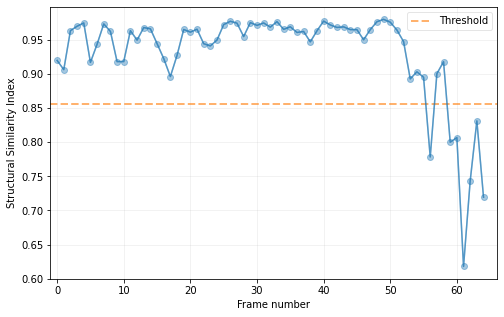

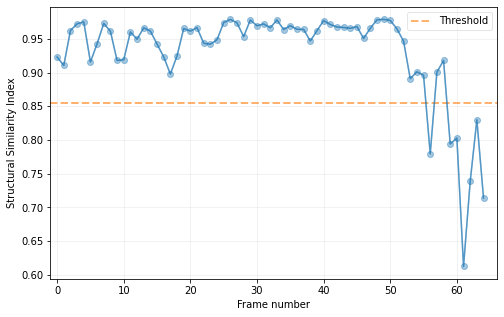

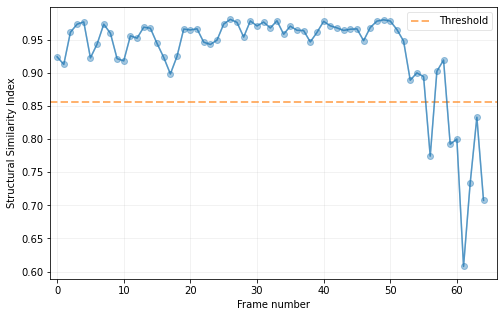

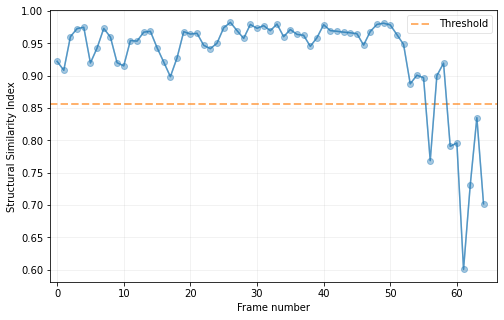

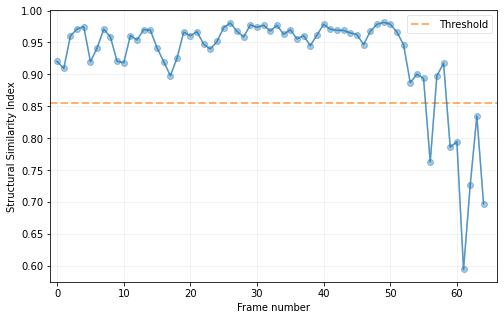

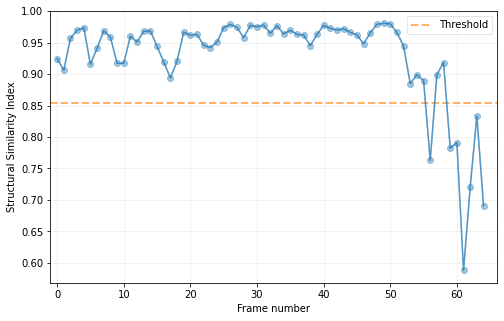

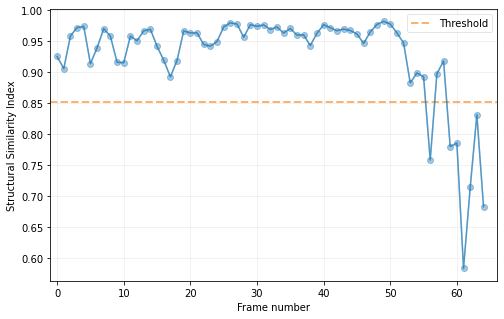

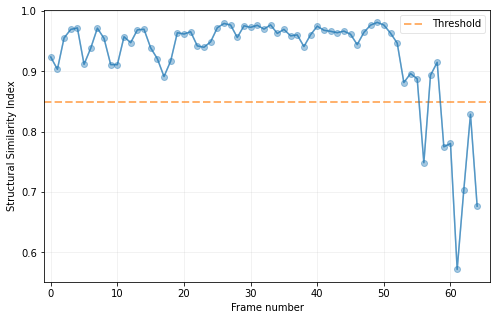

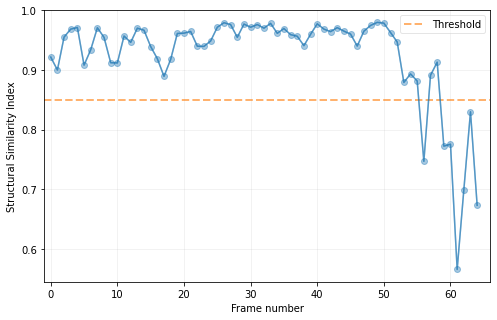

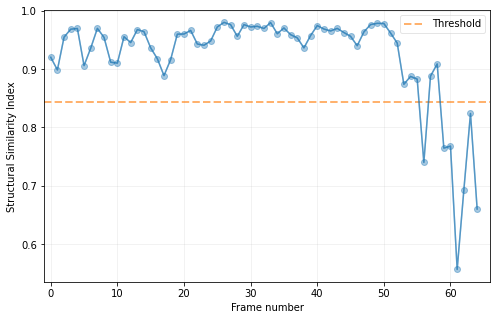

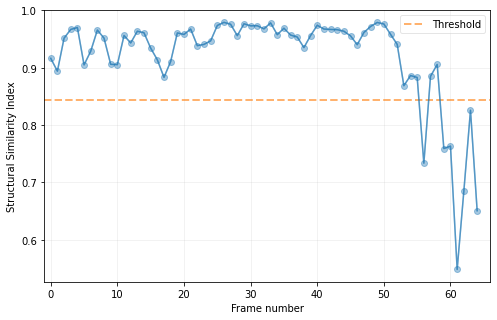

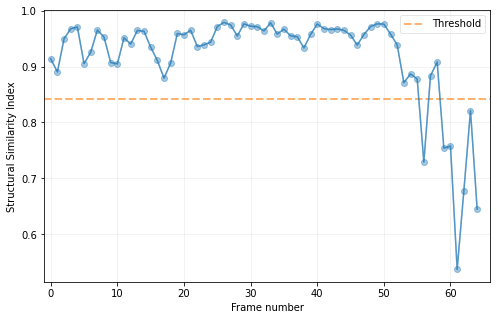

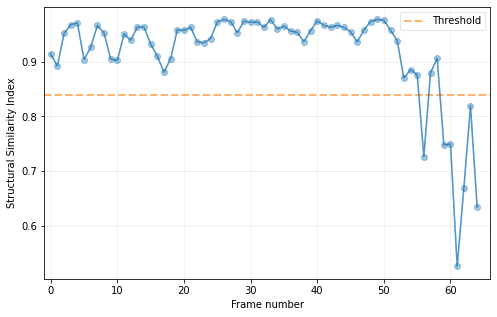

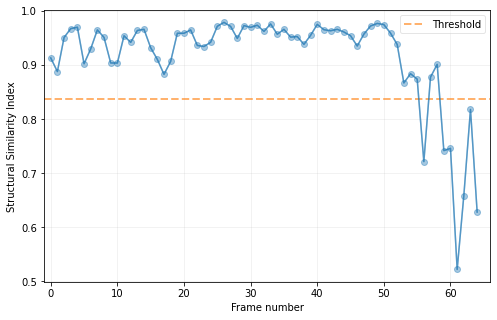

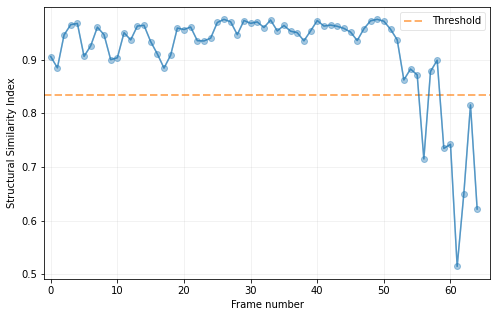

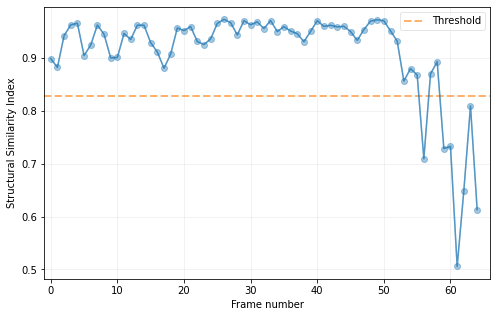

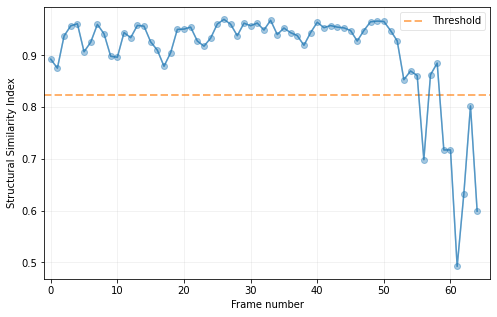

In [30]:
ssim = np.zeros([nch, nz])
for i in range(nch):
    good_idx, bad_idx, ssim[i] = cube_detect_badfr_correlation(cube_corr[i], 
                                                                frame_ref=np.median(cube_corr[i], axis=0), 
                                                                crop_size=61, dist='ssim', percentile=10, 
                                                                mode='annulus', inradius=8, width=18, 
                                                                plot=True, verbose=True, full_output=True)

Note that other distances can be used, such as the Pearson correlation coefficient. 

Although a plot was made for the ADI cube at each wavelength, let's visualize this better by plotting the measured SSIM values for a few different wavelengths, and the average over all channels:

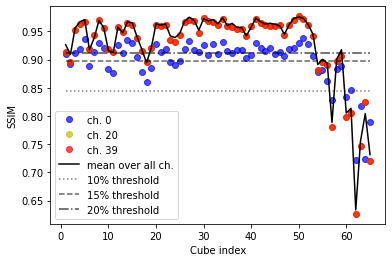

In [31]:
plt.plot(range(1,nz+1), ssim[0], 'bo', label='ch. 0', alpha=0.7)
plt.plot(range(1,nz+1), ssim[20], 'yo', label='ch. 20', alpha=0.7)
plt.plot(range(1,nz+1), ssim[20], 'ro', label='ch. 39', alpha=0.7)
plt.plot(range(1,nz+1), np.mean(ssim,axis=0), 'k', label='mean over all ch.')
plt.plot(range(1,nz+1), [np.percentile(np.mean(ssim,axis=0),10)]*nz, 'k:', alpha=0.5, label='10% threshold')
plt.plot(range(1,nz+1), [np.percentile(np.mean(ssim,axis=0),15)]*nz, 'k--', alpha=0.6, label='15% threshold')
plt.plot(range(1,nz+1), [np.percentile(np.mean(ssim,axis=0),20)]*nz, 'k-.', alpha=0.7, label='20% threshold')
plt.xlabel(r"Cube index")
plt.ylabel(r"SSIM")
plt.legend()

Overall the trends are very similar at all wavelengths: the end of the sequence suffered from much worse conditions, as the dropping SSIM values testify. 

You can finally set a threshold in terms of percentile to remove bad frames depending on your post-processing algorithm (how sensitive it is to very different PSFs) and the regime in which the candidate you are looking after is located (speckle-dominated vs photon noise dominated).

Here, let's consider for example removing the 15% worst frames. THe mean appears to follow closely the last channel, so we'll just get the good indices from the last spectral channel:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-12 17:51:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 10 out of 65 (15.4%)
Running time:  0:00:00.037473
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


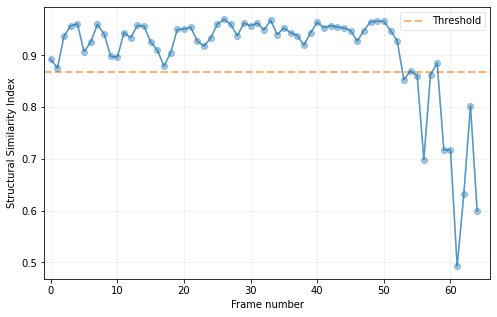

In [32]:
perc_thr = 15
good_idx, bad_idx = cube_detect_badfr_correlation(cube_corr[-1], frame_ref=np.median(cube_corr[-1], axis=0), 
                                                  crop_size=61, dist='ssim', percentile=perc_thr, 
                                                  mode='annulus', inradius=8, width=18, 
                                                  plot=True, verbose=True, full_output=False)

Finally, let's save the master cube and associated parallactic angles after bad frame trim:

In [33]:
write_fits(datpath+'image_cube_sphere2_ready.fits', cube_corr[:,good_idx])
write_fits(datpath+'parallactic_angles_sphere2_ready.fits', pa[:,good_idx])

Fits file successfully overwritten
Fits file successfully overwritten


[Go to the top](#Table-of-contents)